In [1]:
import pandas as pd
import geopandas as gpd
import geopy
import googlemaps
import matplotlib.pyplot as plt
import descartes
from shapely.geometry import Point, Polygon
from numpy import NaN
import requests

### From latitude and longitude, obtain approximated address and block ID for each correctional facility in Arizona

In [2]:
# Key for reverse geocode (obtaining street addresses from pairs of latitude and longitude) using Google API
from key import key
gmaps = googlemaps.Client(key = key)

In [3]:
# Load a list of correctional facilities in the US as of 1/1/2020 from
# https://tigerweb.geo.census.gov/tigerwebmain/Files/bvp20/tigerweb_bvp20_prisons_us.html
correctional = pd.read_excel("Correctional Facilities.xlsx", header = 0)

In [4]:
# Add columns for reverse geocode 
correctional["Street Address"] = NaN
correctional["City"] = NaN
correctional["State"] = NaN
correctional["Zip Code"] = NaN

In [5]:
correctional.head()

,MTFCC,OID,LNDMRKNS,BASENAME,NAME,LSADC,FUNCSTAT,AREALAND,AREAWATER,CENTLAT,CENTLON,INTPTLAT,INTPTLON,Street Address,City,State,Zip Code
0,K1237,1104476287182,NaN,2nd 25th Judicial District Intermediate Sanction,2nd 25th Judicial District Intermediate Sancti...,NaN,NaN,28629,NaN,29.542302,-97.459883,29.542302,-97.459883,NaN,NaN,NaN,NaN
1,K1235,1104486800732,NaN,3-B,3-B Detention Ctr,NaN,NaN,7613,NaN,43.515659,-112.014626,43.515659,-112.014626,NaN,NaN,NaN,NaN
2,K1235,1104492849218,NaN,30th Circuit Youth Services,30th Circuit Youth Services,NaN,NaN,6132,NaN,37.610773,-93.411794,37.610773,-93.411794,NaN,NaN,NaN,NaN
3,K1238,1104483205318,NaN,38th Judicial District Community Corrections,38th Judicial District Community Corrections F...,NaN,NaN,12671,NaN,29.232388,-99.792426,29.232388,-99.792426,NaN,NaN,NaN,NaN
4,K1236,1104485342733,NaN,77th Street Regional,77th Street Regional Jail,NaN,NaN,16408,NaN,33.970322,-118.277467,33.970322,-118.277467,NaN,NaN,NaN,NaN


In [6]:
# Support method for reverse geocode
def get_address_components(address):
    street_number = street_name = city = state = zip_code = ""
    for i in range (len(address)):
        type = address[i]["types"]
        if (type == ['street_number']):
            street_number = address[i]["long_name"]
        if (type == ['route']):
            street_name = address[i]["long_name"]
        if (type == ['locality', 'political']):
            city = address[i]["long_name"] 
        if (type == ['political', 'sublocality', 'sublocality_level_1']):
            city = address[i]["long_name"] 
        if (type == ['administrative_area_level_1', 'political']):
            state = address[i]["short_name"]
        if (type == ['postal_code']):
            zip_code = address[i]["long_name"]
    return street_number, street_name, city, state, zip_code

In [7]:
# Use reverse geocode and add results to the 'correctional' dataframe
for i in range(len(correctional)):
    # get list of addresses from lat and lon
    result = gmaps.reverse_geocode((correctional["CENTLAT"][i],correctional["CENTLON"][i]))
    # get the first address in list (at index 0) -- usually the closest to the actual address
    address = result[0]['address_components']
    components = get_address_components(address)
    # street address
    correctional.loc[i,"Street Address"] = components[0] + " " +  components[1]
    # city 
    correctional.loc[i,"City"] = components[2]
    # state
    correctional.loc[i,"State"] = components[3]
    # zip code
    correctional.loc[i,"Zip Code"] = components[4]

In [8]:
correctional.head()

,MTFCC,OID,LNDMRKNS,BASENAME,NAME,LSADC,FUNCSTAT,AREALAND,AREAWATER,CENTLAT,CENTLON,INTPTLAT,INTPTLON,Street Address,City,State,Zip Code
0,K1237,1104476287182,NaN,2nd 25th Judicial District Intermediate Sanction,2nd 25th Judicial District Intermediate Sancti...,NaN,NaN,28629,NaN,29.542302,-97.459883,29.542302,-97.459883,4024 Farm to Market Road 794,Gonzales,TX,78629
1,K1235,1104486800732,NaN,3-B,3-B Detention Ctr,NaN,NaN,7613,NaN,43.515659,-112.014626,43.515659,-112.014626,950 Environmental Way,Idaho Falls,ID,83401
2,K1235,1104492849218,NaN,30th Circuit Youth Services,30th Circuit Youth Services,NaN,NaN,6132,NaN,37.610773,-93.411794,37.610773,-93.411794,211 West Walnut Street,Bolivar,MO,65613
3,K1238,1104483205318,NaN,38th Judicial District Community Corrections,38th Judicial District Community Corrections F...,NaN,NaN,12671,NaN,29.232388,-99.792426,29.232388,-99.792426,401 East Front Street,Uvalde,TX,78801
4,K1236,1104485342733,NaN,77th Street Regional,77th Street Regional Jail,NaN,NaN,16408,NaN,33.970322,-118.277467,33.970322,-118.277467,7600 South Broadway,Los Angeles,CA,90003


In [9]:
# Save data frame
correctional.to_csv("Correctional Facilities with Addresses.csv")

In [10]:
# Filter AZ correctional facilities
correctional_AZ = correctional[correctional.State == "AZ"]
correctional_AZ.insert(0, "Number", list(range(1, len(correctional_AZ)+1)), False) # unique IDs
correctional_AZ.head()

,Number,MTFCC,OID,LNDMRKNS,BASENAME,NAME,LSADC,FUNCSTAT,AREALAND,AREAWATER,CENTLAT,CENTLON,INTPTLAT,INTPTLON,Street Address,City,State,Zip Code
13,1,K1235,1104486527629,NaN,Acatalina Mountain,Acatalina Mountain Schl,NaN,NaN,414298,NaN,32.470617,-110.921499,32.470617,-110.921499,14500 North Oracle Road,Tucson,AZ,85739
48,2,K1235,1104484269726,NaN,Adobe Mountain,Adobe Mountain Schl,NaN,NaN,284023,NaN,33.702954,-112.119465,33.702954,-112.119465,2800 West Pinnacle Peak Road,Phoenix,AZ,85027
56,3,K1236,1104486582323,NaN,Ak-Chin Tribal Police and,Ak-Chin Tribal Police and Detention Ctr,NaN,NaN,5076,NaN,33.029520,-112.075844,33.029520,-112.075844,47297 West Farrell Road,Maricopa,AZ,85139
172,4,K1236,1104475873387,NaN,Apache County,Apache County Detention Ctr,NaN,NaN,19443,NaN,34.502063,-109.365131,34.502063,-109.365131,70 West 3rd Street South,Saint Johns,AZ,85936
173,5,K1235,1104486478876,NaN,Apache County Juvenile,Apache County Juvenile Detention Ctr,NaN,NaN,3924,NaN,34.506474,-109.365272,34.506474,-109.365272,50 West Cleveland Street,Saint Johns,AZ,85936


In [11]:
# Load AZ block-level shapefile from Census at link
# https://catalog.data.gov/dataset/tiger-line-shapefile-2017-2010-state-arizona-2010-census-block-state-based
az_map = gpd.read_file("tl_2017_04_tabblock10.shp")

# Create a new data frame with Point ("geometry") from lat and lon 
proj = az_map.crs
geometry = [Point(xy) for xy in zip(correctional_AZ["CENTLON"], correctional_AZ["CENTLAT"])]
gdf = gpd.GeoDataFrame(correctional_AZ, crs = proj, geometry = geometry)
gdf.head()

,Number,MTFCC,OID,LNDMRKNS,BASENAME,NAME,LSADC,FUNCSTAT,AREALAND,AREAWATER,CENTLAT,CENTLON,INTPTLAT,INTPTLON,Street Address,City,State,Zip Code,geometry
13,1,K1235,1104486527629,NaN,Acatalina Mountain,Acatalina Mountain Schl,NaN,NaN,414298,NaN,32.470617,-110.921499,32.470617,-110.921499,14500 North Oracle Road,Tucson,AZ,85739,POINT (-110.92150 32.47062)
48,2,K1235,1104484269726,NaN,Adobe Mountain,Adobe Mountain Schl,NaN,NaN,284023,NaN,33.702954,-112.119465,33.702954,-112.119465,2800 West Pinnacle Peak Road,Phoenix,AZ,85027,POINT (-112.11946 33.70295)
56,3,K1236,1104486582323,NaN,Ak-Chin Tribal Police and,Ak-Chin Tribal Police and Detention Ctr,NaN,NaN,5076,NaN,33.029520,-112.075844,33.029520,-112.075844,47297 West Farrell Road,Maricopa,AZ,85139,POINT (-112.07584 33.02952)
172,4,K1236,1104475873387,NaN,Apache County,Apache County Detention Ctr,NaN,NaN,19443,NaN,34.502063,-109.365131,34.502063,-109.365131,70 West 3rd Street South,Saint Johns,AZ,85936,POINT (-109.36513 34.50206)
173,5,K1235,1104486478876,NaN,Apache County Juvenile,Apache County Juvenile Detention Ctr,NaN,NaN,3924,NaN,34.506474,-109.365272,34.506474,-109.365272,50 West Cleveland Street,Saint Johns,AZ,85936,POINT (-109.36527 34.50647)


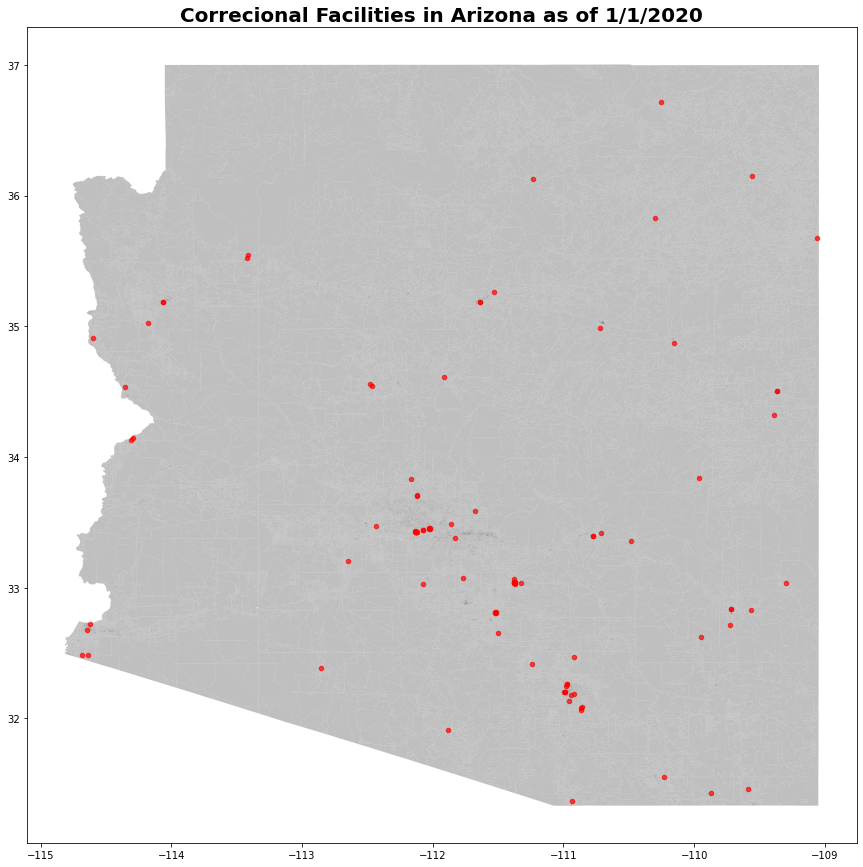

In [12]:
# Plot the points on an AZ map
fig, ax = plt.subplots(figsize=(15,15))
az_map.plot(ax = ax, alpha = 0.5, color = "grey")

gdf.plot(ax = ax, alpha = 0.7, color = "red", markersize = 20)
plt.title("Correcional Facilities in Arizona as of 1/1/2020", fontsize = 20, fontweight = "bold")
plt.show()

In [13]:
print("Number of correctional facilities plotted above: ", len(correctional_AZ))

Number of correctional facilities plotted above:  100


In [14]:
# Data frame for Census Geocoder
prisons_AZ = correctional_AZ[{"Number","Street Address", "City", "State", "Zip Code"}]
prisons_AZ = prisons_AZ[["Number","Street Address", "City", "State", "Zip Code"]]
prisons_AZ

,Number,Street Address,City,State,Zip Code
13,1,14500 North Oracle Road,Tucson,AZ,85739
48,2,2800 West Pinnacle Peak Road,Phoenix,AZ,85027
56,3,47297 West Farrell Road,Maricopa,AZ,85139
172,4,70 West 3rd Street South,Saint Johns,AZ,85936
173,5,50 West Cleveland Street,Saint Johns,AZ,85936
...,...,...,...,...,...
6266,96,960 Division Street,Prescott,AZ,86301
6298,97,145 South 2nd Avenue,Yuma,AZ,85364
6299,98,2440 West 28th Street,Yuma,AZ,85364
6320,99,5501 North La Palma Road,Eloy,AZ,85131


In [15]:
# Save data frame
prisons_AZ.to_csv("AZ Correctional Facilities.csv", index = False)

See [instructions](https://www2.census.gov/geo/pdfs/maps-data/data/FAQ_for_Census_Bureau_Public_Geocoder.pdf) for the Census Geocoder to "Find Geographies Using... Address Batch". Use the [Census Geocoder](https://geocoding.geo.census.gov/geocoder/geographies/addressbatch?form) to get the Block ID for each correctional facility using its approximated street address, choosing benchmark "Public_AR_Current" and vintage "Current Current". 

In [16]:
# Load the file downloaded from the Census Geocoder
# See Appendix D in the instructions above for column names and metadata
prisons_AZ_block = pd.read_csv("AZGeocodeResults.csv", 
                               names = ["NUMBER", "INPUT ADDRESS", "MATCH INDICATOR", "MATCH TYPE",
                                       "OUTPUT ADDRESS", "LAT LON", "TIGERLINE ID", "TIGERLINE ID SIDE", 
                                       "STATE CODE", "COUNTY CODE", "TRACT CODE", "BLOCK CODE"])

In [17]:
prisons_AZ_block.head()

,NUMBER,INPUT ADDRESS,MATCH INDICATOR,MATCH TYPE,OUTPUT ADDRESS,LAT LON,TIGERLINE ID,TIGERLINE ID SIDE,STATE CODE,COUNTY CODE,TRACT CODE,BLOCK CODE
0,88,"1275 West Starr Pass Boulevard, Tucson, AZ, 85713",Match,Exact,"1275 W STARR PASS BLVD, TUCSON, AZ, 85713","-110.99059,32.20579",121169711.0,R,4.0,19.0,2501.0,4010.0
1,89,"Main Road, Sells, AZ, 85634",No_Match,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,90,"947 Rodeo Way, Peach Springs, AZ, 86434",No_Match,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,91,"6420 South Park Avenue, Tucson, AZ, 85706",Match,Exact,"6420 S PARK AVE, TUCSON, AZ, 85706","-110.95625,32.134907",638281436.0,R,4.0,19.0,3702.0,2019.0
4,92,"9300 South Wilmot Road, Tucson, AZ, 85756",Match,Exact,"9300 S WILMOT RD, TUCSON, AZ, 85756","-110.85797,32.08239",121201245.0,L,4.0,19.0,410502.0,1158.0


In [18]:
# Filter matched addresses
prisons_AZ_block = prisons_AZ_block[prisons_AZ_block["MATCH INDICATOR"] == "Match"]
prisons_AZ_block.head()

,NUMBER,INPUT ADDRESS,MATCH INDICATOR,MATCH TYPE,OUTPUT ADDRESS,LAT LON,TIGERLINE ID,TIGERLINE ID SIDE,STATE CODE,COUNTY CODE,TRACT CODE,BLOCK CODE
0,88,"1275 West Starr Pass Boulevard, Tucson, AZ, 85713",Match,Exact,"1275 W STARR PASS BLVD, TUCSON, AZ, 85713","-110.99059,32.20579",121169711.0,R,4.0,19.0,2501.0,4010.0
3,91,"6420 South Park Avenue, Tucson, AZ, 85706",Match,Exact,"6420 S PARK AVE, TUCSON, AZ, 85706","-110.95625,32.134907",638281436.0,R,4.0,19.0,3702.0,2019.0
4,92,"9300 South Wilmot Road, Tucson, AZ, 85756",Match,Exact,"9300 S WILMOT RD, TUCSON, AZ, 85756","-110.85797,32.08239",121201245.0,L,4.0,19.0,410502.0,1158.0
5,93,"5 East Sycamore Street, Whiteriver, AZ, 85941",Match,Exact,"5 E SYCAMORE ST, WHITERIVER, AZ, 85941","-109.9643,33.839073",638274603.0,R,4.0,17.0,940302.0,1032.0
6,94,"255 East Gurley Street, Prescott, AZ, 86301",Match,Exact,"255 E GURLEY ST, PRESCOTT, AZ, 86301","-112.46623,34.541843",635913890.0,L,4.0,25.0,801.0,2010.0


In [19]:
# Check non-exact matches -- they are acceptable 
prisons_AZ_block[prisons_AZ_block["MATCH TYPE"] == "Non_Exact"]

,NUMBER,INPUT ADDRESS,MATCH INDICATOR,MATCH TYPE,OUTPUT ADDRESS,LAT LON,TIGERLINE ID,TIGERLINE ID SIDE,STATE CODE,COUNTY CODE,TRACT CODE,BLOCK CODE
25,4,"70 West 3rd Street South, Saint Johns, AZ, 85936",Match,Non_Exact,"70 E 3RD ST S, SAINT JOHNS, AZ, 85936","-109.3632,34.502735",172042808.0,L,4.0,1.0,970300.0,2028.0
42,31,"8870 Mary's Drive, Flagstaff, AZ, 86004",Match,Non_Exact,"8870 MARYS DR, FLAGSTAFF, AZ, 86004","-111.53121,35.267605",638060242.0,R,4.0,5.0,1301.0,1055.0
43,32,"3443 South Richey Boulevard, Tucson, AZ, 85713",Match,Non_Exact,"3443 S RICHEY AVE, TUCSON, AZ, 85713","-110.91683,32.184532",638279158.0,L,4.0,19.0,2100.0,1037.0
45,34,"1705 East Hanna Road, Eloy, AZ, 85131",Match,Non_Exact,"1705 W HANNA RD, ELOY, AZ, 85131","-111.58596,32.82117",129188347.0,R,4.0,21.0,2001.0,1185.0
56,45,"1425 East South Street, Globe, AZ, 85501",Match,Non_Exact,"1425 SOUTH ST, GLOBE, AZ, 85501","-110.769005,33.39545",159336574.0,L,4.0,7.0,1200.0,1025.0


In [20]:
print("Number of matched facilities: ", len(prisons_AZ_block))

Number of matched facilities:  66


In [21]:
# Merge two dataframes 
prisons_AZ_block = prisons_AZ_block.rename(columns = {'NUMBER':'Number'})
correctional_AZ.dropna(subset = ["Number"])
correctional_AZ["Number"] = correctional_AZ["Number"].astype(int)
prisons_AZ_block["Number"] = prisons_AZ_block["Number"].astype(int)
merged = pd.merge(correctional_AZ, prisons_AZ_block, on = "Number", how= "left", indicator = True)
merged = merged[merged["MATCH INDICATOR"] == "Match"]
merged

D:\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Number,MTFCC,OID,LNDMRKNS,BASENAME,NAME,LSADC,FUNCSTAT,AREALAND,AREAWATER,...,MATCH TYPE,OUTPUT ADDRESS,LAT LON,TIGERLINE ID,TIGERLINE ID SIDE,STATE CODE,COUNTY CODE,TRACT CODE,BLOCK CODE,_merge
0,1,K1235,1104486527629,NaN,Acatalina Mountain,Acatalina Mountain Schl,NaN,NaN,414298,NaN,...,Exact,"14500 N ORACLE RD, TUCSON, AZ, 85739","-110.92473,32.469364",638279047.0,R,4.0,19.0,4716.0,1032.0,both
1,2,K1235,1104484269726,NaN,Adobe Mountain,Adobe Mountain Schl,NaN,NaN,284023,NaN,...,Exact,"2800 W PINNACLE PEAK RD, PHOENIX, AZ, 85027","-112.119514,33.69953",128431214.0,L,4.0,13.0,611900.0,1030.0,both
3,4,K1236,1104475873387,NaN,Apache County,Apache County Detention Ctr,NaN,NaN,19443,NaN,...,Non_Exact,"70 E 3RD ST S, SAINT JOHNS, AZ, 85936","-109.3632,34.502735",172042808.0,L,4.0,1.0,970300.0,2028.0,both
4,5,K1235,1104486478876,NaN,Apache County Juvenile,Apache County Juvenile Detention Ctr,NaN,NaN,3924,NaN,...,Exact,"50 W CLEVELAND ST, SAINT JOHNS, AZ, 85936","-109.365875,34.506798",638271234.0,L,4.0,1.0,970300.0,2004.0,both
8,9,K1237,1104486584653,NaN,Arizona State Prison Complex Florence Picacho ...,Arizona State Prison Complex Florence Picacho ...,NaN,NaN,286613,NaN,...,Exact,"24890 S PICACHO HWY, ELOY, AZ, 85131","-111.499596,32.64923",638288267.0,L,4.0,21.0,2102.0,2064.0,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,K1235,1104486514813,NaN,Yavapai County Juvenile,Yavapai County Juvenile Detention Ctr,NaN,NaN,6199,NaN,...,Exact,"960 DIVISION ST, PRESCOTT, AZ, 86301","-112.47918,34.557972",648333561.0,L,4.0,25.0,900.0,2000.0,both
96,97,K1236,1104486517105,NaN,Yuma County Adult,Yuma County Adult Detention Ctr,NaN,NaN,35760,NaN,...,Exact,"145 S 2ND AVE, YUMA, AZ, 85364","-114.62213,32.723656",635777908.0,L,4.0,27.0,100.0,1035.0,both
97,98,K1235,1104486517383,NaN,Yuma County Juvenile Justice,Yuma County Juvenile Justice Ctr,NaN,NaN,24449,NaN,...,Exact,"2440 W 28TH ST, YUMA, AZ, 85364","-114.64958,32.676743",636843227.0,R,4.0,27.0,907.0,1054.0,both
98,99,K1237,1104486591389,NaN,la Palma Correctional,la Palma Correctional Ctr,NaN,NaN,286968,NaN,...,Exact,"5501 N LA PALMA RD, ELOY, AZ, 85131","-111.53259,32.820816",129188266.0,R,4.0,21.0,2002.0,2000.0,both


In [22]:
# Get Block IDs and Tract IDs, with same format as in
# https://www.census.gov/programs-surveys/geography/guidance/geo-identifiers.html#:~:text=What%20are%20GEOIDs%3F&text=GEOIDs%20are%20numeric%20codes%20that,area%20has%20a%20unique%20GEOID.
# from the Hierarchy Diagrams table

merged["STATE CODE"] = merged["STATE CODE"].astype(int).astype(str)
merged["COUNTY CODE"] = merged["COUNTY CODE"].astype(int).astype(str)
merged["TRACT CODE"] = merged["TRACT CODE"].astype(int).astype(str)
merged["BLOCK CODE"] = merged["BLOCK CODE"].astype(int).astype(str)

merged["STATE CODE"] = merged["STATE CODE"].str.zfill(2)
merged["COUNTY CODE"] = merged["COUNTY CODE"].str.zfill(3)
merged["TRACT CODE"] = merged["TRACT CODE"].str.zfill(6)
merged["BLOCK CODE"] = merged["BLOCK CODE"].str.zfill(4)

merged["TRACT ID"] = merged["STATE CODE"] + merged["COUNTY CODE"] + merged["TRACT CODE"]
merged["BLOCK ID"] = merged["STATE CODE"] + merged["COUNTY CODE"] + merged["TRACT CODE"] + merged["BLOCK CODE"]

In [23]:
merged[["STATE CODE", "COUNTY CODE", "TRACT CODE", "BLOCK CODE", "TRACT ID", "BLOCK ID"]]

,STATE CODE,COUNTY CODE,TRACT CODE,BLOCK CODE,TRACT ID,BLOCK ID
0,04,019,004716,1032,04019004716,040190047161032
1,04,013,611900,1030,04013611900,040136119001030
3,04,001,970300,2028,04001970300,040019703002028
4,04,001,970300,2004,04001970300,040019703002004
8,04,021,002102,2064,04021002102,040210021022064
...,...,...,...,...,...,...
95,04,025,000900,2000,04025000900,040250009002000
96,04,027,000100,1035,04027000100,040270001001035
97,04,027,000907,1054,04027000907,040270009071054
98,04,021,002002,2000,04021002002,040210020022000


### Add prison population data from 2010 Census Summary File 1

The following data is from the 2010 Census Summary File 1. The choice of variables and keys are based on the [Technical Documentation](https://www2.census.gov/programs-surveys/decennial/2010/technical-documentation/complete-tech-docs/summary-file/sf1.pdf?#) and [Variable List](https://api.census.gov/data/2010/dec/sf1/variables.html).

**At block level**

At the block level, we can get data about the population in correctional facilities for adults and in juvenile facilities. However, we cannot break down that data into types of correctional facilities. That's what we are going to do at the tract level.

In [24]:
# Variables of interest 
variables = [
    "P042003",
    "P042004"
]

keys = [
    "Adult Pop",
    "Juvenile Pop"
]

In [25]:
# Code chunk by Melisande Teng 

def counties(state_fips):
    resp = requests.get(
        "https://api.census.gov/data/2010/dec/sf1"
        "?get=NAME&for=county:*&in=state:{}".format(state_fips)
    )
    header, *rows = resp.json()
    county_column_index = header.index("county")
    county_fips_codes = set(row[county_column_index] for row in rows)
    return county_fips_codes

def block_data_for_county(state_fips, county_fips, variables=variables, keys=keys):
    url = (
        "https://api.census.gov/data/2010/dec/sf1"
        + "?get={},NAME&for=block:*".format(",".join(variables))
        + "&in=state:{}&in=county:{}&in=tract:*".format(state_fips, county_fips)
    )
    resp = requests.get(url)
    header, *rows = resp.json()
    variable_lookup = dict(zip(variables, keys))
    columns = [variable_lookup.get(column_name, column_name) for column_name in header]
    dtypes = {key: int for key in keys}
    dtypes.update({key: str for key in ["state", "county", "tract", "block"]})
    data = pd.DataFrame.from_records(rows, columns=columns).astype(dtypes)
    data["geoid"] = data["state"] + data["county"] + data["tract"] + data["block"]
    return data


def block_data_for_state(state_fips):
    from tqdm.auto import tqdm
    county_fips_codes = counties(state_fips)
    return pd.concat(
        [
            block_data_for_county(state_fips, county_fips)
            for county_fips in tqdm(county_fips_codes)
        ]
    )

In [26]:
# Filter AZ blocks
prisons_pop_block = block_data_for_state('04') 

In [27]:
# Rename column for block-level merge
prisons_pop_block = prisons_pop_block.rename(columns = {'geoid':'BLOCK ID'})
prisons_pop_block.head()

,Adult Pop,Juvenile Pop,NAME,state,county,tract,block,BLOCK ID
0,0,0,"Block 1000, Block Group 1, Census Tract 9660, ...",04,023,966000,1000,040239660001000
1,0,0,"Block 1001, Block Group 1, Census Tract 9660, ...",04,023,966000,1001,040239660001001
2,0,0,"Block 1013, Block Group 1, Census Tract 9660, ...",04,023,966000,1013,040239660001013
3,0,0,"Block 1048, Block Group 1, Census Tract 9660, ...",04,023,966000,1048,040239660001048
4,0,0,"Block 1039, Block Group 1, Census Tract 9660, ...",04,023,966000,1039,040239660001039


In [28]:
# Merge two data frames on block level
prisons_pop_block_AZ = pd.merge(merged, prisons_pop_block, on = "BLOCK ID", how= "left", indicator = "exists")
prisons_pop_block_AZ.head()

,Number,MTFCC,OID,LNDMRKNS,BASENAME,NAME_x,LSADC,FUNCSTAT,AREALAND,AREAWATER,...,TRACT ID,BLOCK ID,Adult Pop,Juvenile Pop,NAME_y,state,county,tract,block,exists
0,1,K1235,1104486527629,NaN,Acatalina Mountain,Acatalina Mountain Schl,NaN,NaN,414298,NaN,...,04019004716,040190047161032,0,65,"Block 1032, Block Group 1, Census Tract 47.16,...",04,019,004716,1032,both
1,2,K1235,1104484269726,NaN,Adobe Mountain,Adobe Mountain Schl,NaN,NaN,284023,NaN,...,04013611900,040136119001030,0,248,"Block 1030, Block Group 1, Census Tract 6119, ...",04,013,611900,1030,both
2,4,K1236,1104475873387,NaN,Apache County,Apache County Detention Ctr,NaN,NaN,19443,NaN,...,04001970300,040019703002028,0,0,"Block 2028, Block Group 2, Census Tract 9703, ...",04,001,970300,2028,both
3,5,K1235,1104486478876,NaN,Apache County Juvenile,Apache County Juvenile Detention Ctr,NaN,NaN,3924,NaN,...,04001970300,040019703002004,0,0,"Block 2004, Block Group 2, Census Tract 9703, ...",04,001,970300,2004,both
4,9,K1237,1104486584653,NaN,Arizona State Prison Complex Florence Picacho ...,Arizona State Prison Complex Florence Picacho ...,NaN,NaN,286613,NaN,...,04021002102,040210021022064,183,0,"Block 2064, Block Group 2, Census Tract 21.02,...",04,021,002102,2064,both


In [29]:
prisons_pop_block_AZ.drop_duplicates(inplace = True)

In [30]:
print(len(prisons_pop_block_AZ["OID"].unique()))
print(len(prisons_pop_block_AZ["BLOCK ID"].unique()))

66
58


**Since there are 66 correctional facilities and 58 unique Census blocks, there are at least 2 correctional facilities in the same Census block.** 

In [31]:
# Create a new data frame with Point ("geometry") from lat and lon 
proj = az_map.crs
geometry = [Point(xy) for xy in zip(prisons_pop_block_AZ["CENTLON"], prisons_pop_block_AZ["CENTLAT"])]
gdf = gpd.GeoDataFrame(prisons_pop_block_AZ, crs = proj, geometry = geometry)
gdf.head()

,Number,MTFCC,OID,LNDMRKNS,BASENAME,NAME_x,LSADC,FUNCSTAT,AREALAND,AREAWATER,...,TRACT ID,BLOCK ID,Adult Pop,Juvenile Pop,NAME_y,state,county,tract,block,exists
0,1,K1235,1104486527629,NaN,Acatalina Mountain,Acatalina Mountain Schl,NaN,NaN,414298,NaN,...,04019004716,040190047161032,0,65,"Block 1032, Block Group 1, Census Tract 47.16,...",04,019,004716,1032,both
1,2,K1235,1104484269726,NaN,Adobe Mountain,Adobe Mountain Schl,NaN,NaN,284023,NaN,...,04013611900,040136119001030,0,248,"Block 1030, Block Group 1, Census Tract 6119, ...",04,013,611900,1030,both
2,4,K1236,1104475873387,NaN,Apache County,Apache County Detention Ctr,NaN,NaN,19443,NaN,...,04001970300,040019703002028,0,0,"Block 2028, Block Group 2, Census Tract 9703, ...",04,001,970300,2028,both
3,5,K1235,1104486478876,NaN,Apache County Juvenile,Apache County Juvenile Detention Ctr,NaN,NaN,3924,NaN,...,04001970300,040019703002004,0,0,"Block 2004, Block Group 2, Census Tract 9703, ...",04,001,970300,2004,both
4,9,K1237,1104486584653,NaN,Arizona State Prison Complex Florence Picacho ...,Arizona State Prison Complex Florence Picacho ...,NaN,NaN,286613,NaN,...,04021002102,040210021022064,183,0,"Block 2064, Block Group 2, Census Tract 21.02,...",04,021,002102,2064,both


In [32]:
# Save to data frame
gdf = gdf.drop(["Number"], axis=1)
gdf.to_csv("AZ Prisons with Block-level Prison Populations.csv", index = False)

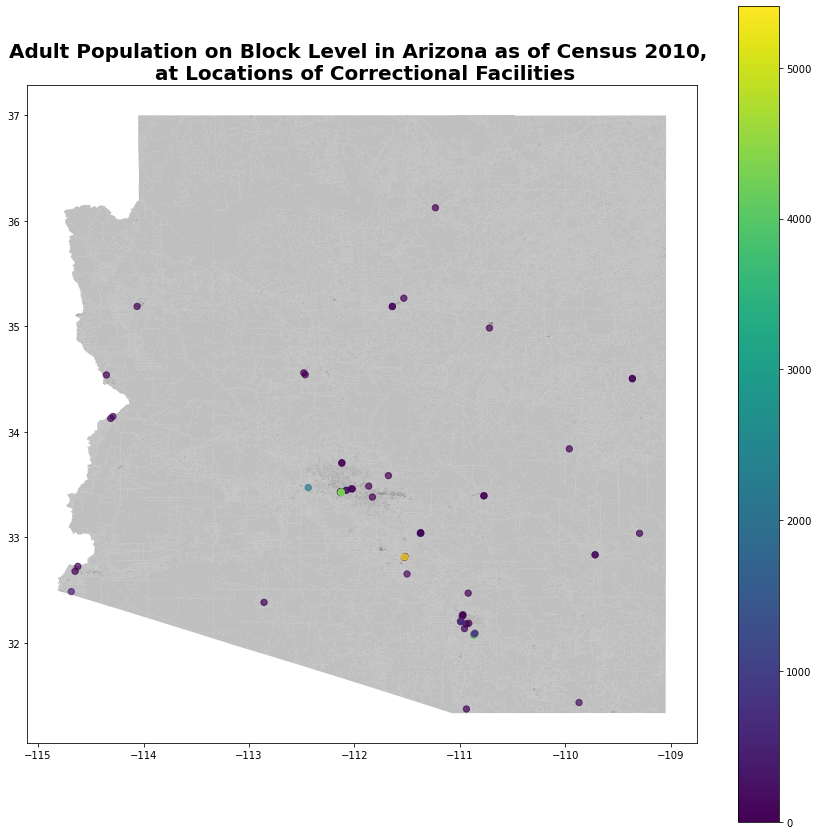

In [33]:
# Plot adult population data on an AZ map 
fig, ax = plt.subplots(figsize=(15,15))
az_map.plot(ax = ax, alpha = 0.5, color = "grey")

gdf.plot(column = "Adult Pop", ax = ax, alpha = 0.7, markersize = 40, legend = True)
plt.title("Adult Population on Block Level in Arizona as of Census 2010, \n at Locations of Correctional Facilities", fontsize = 20, fontweight = "bold")
plt.show()

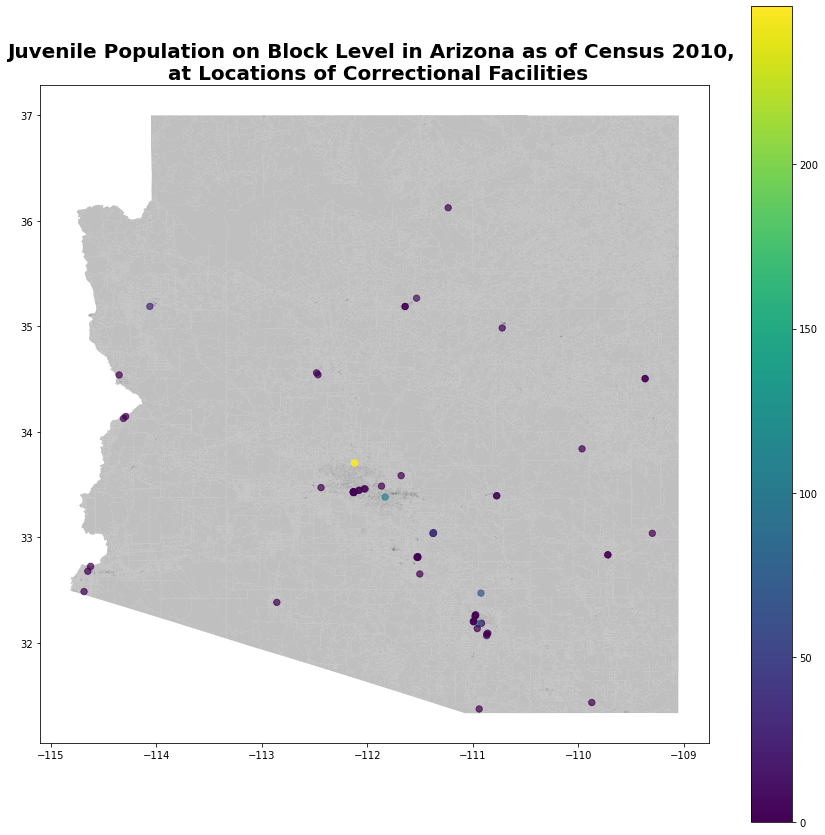

In [34]:
# Plot juvenile population data on an AZ map 
fig, ax = plt.subplots(figsize=(15,15))
az_map.plot(ax = ax, alpha = 0.5, color = "grey")

gdf.plot(column = "Juvenile Pop", ax = ax, alpha = 0.7, markersize = 40, legend = True)
plt.title("Juvenile Population on Block Level in Arizona as of Census 2010, \n at Locations of Correctional Facilities", fontsize = 20, fontweight = "bold")
plt.show()

**At tract level**

At the track level, we can get the break-down data of population in correctional facilities at different levels (federal, state, local, residential and military) for adult populations.

In [35]:
# Variables of interest
variables = [
    "PCT020003",
    "PCT020004",
    "PCT020005",
    "PCT020006",
    "PCT020007",
    "PCT020008",
    "PCT020009",
    "PCT020010",
    "PCT020013"
]

keys = [
    "Adult Pop",
    "Federal Detention Centers - Adult Pop",
    "Federal Prisons - Adult Pop",
    "State Prisons - Adult Pop",
    "Local Jails - Adult Pop",
    "Residential - Adult Pop",
    "Military - Adult Pop",
    "Juvenile Pop",
    "Correctional -  Juvenile Pop"
]

In [36]:
def counties(state_fips):
    resp = requests.get(
        "https://api.census.gov/data/2010/dec/sf1"
        "?get=NAME&for=county:*&in=state:{}".format(state_fips)
    )
    header, *rows = resp.json()
    county_column_index = header.index("county")
    county_fips_codes = set(row[county_column_index] for row in rows)
    return county_fips_codes

def tract_data_for_county(state_fips, county_fips, variables=variables, keys=keys):
    url = (
        "https://api.census.gov/data/2010/dec/sf1"
        + "?get={},NAME&for=tract:*".format(",".join(variables))
        + "&in=state:{}&in=county:*".format(state_fips, county_fips)
    )
    resp = requests.get(url)
    header, *rows = resp.json()
    variable_lookup = dict(zip(variables, keys))
    columns = [variable_lookup.get(column_name, column_name) for column_name in header]
    dtypes = {key: int for key in keys}
    dtypes.update({key: str for key in ["state", "county", "tract"]})
    data = pd.DataFrame.from_records(rows, columns=columns).astype(dtypes)
    data["geoid"] = data["state"] + data["county"] + data["tract"] 
    return data


def tract_data_for_state(state_fips):
    from tqdm.auto import tqdm
    county_fips_codes = counties(state_fips)
    return pd.concat(
        [
            tract_data_for_county(state_fips, county_fips)
            for county_fips in tqdm(county_fips_codes)
        ]
    )

In [37]:
# Filter AZ tracts
prisons_pop_tract = tract_data_for_state('04') # For AZ only

In [38]:
prisons_pop_tract.head()

,Adult Pop,Federal Detention Centers - Adult Pop,Federal Prisons - Adult Pop,State Prisons - Adult Pop,Local Jails - Adult Pop,Residential - Adult Pop,Military - Adult Pop,Juvenile Pop,Correctional - Juvenile Pop,NAME,state,county,tract,geoid
0,0,0,0,0,0,0,0,0,0,"Census Tract 822.05, Maricopa County, Arizona",04,013,082205,04013082205
1,0,0,0,0,0,0,0,0,0,"Census Tract 822.06, Maricopa County, Arizona",04,013,082206,04013082206
2,0,0,0,0,0,0,0,0,0,"Census Tract 822.07, Maricopa County, Arizona",04,013,082207,04013082207
3,0,0,0,0,0,0,0,0,0,"Census Tract 822.08, Maricopa County, Arizona",04,013,082208,04013082208
4,0,0,0,0,0,0,0,0,0,"Census Tract 822.09, Maricopa County, Arizona",04,013,082209,04013082209


In [39]:
# Rename column for block-level merge
prisons_pop_tract = prisons_pop_tract.rename(columns = {'geoid':'TRACT ID'})
prisons_pop_tract.head()

,Adult Pop,Federal Detention Centers - Adult Pop,Federal Prisons - Adult Pop,State Prisons - Adult Pop,Local Jails - Adult Pop,Residential - Adult Pop,Military - Adult Pop,Juvenile Pop,Correctional - Juvenile Pop,NAME,state,county,tract,TRACT ID
0,0,0,0,0,0,0,0,0,0,"Census Tract 822.05, Maricopa County, Arizona",04,013,082205,04013082205
1,0,0,0,0,0,0,0,0,0,"Census Tract 822.06, Maricopa County, Arizona",04,013,082206,04013082206
2,0,0,0,0,0,0,0,0,0,"Census Tract 822.07, Maricopa County, Arizona",04,013,082207,04013082207
3,0,0,0,0,0,0,0,0,0,"Census Tract 822.08, Maricopa County, Arizona",04,013,082208,04013082208
4,0,0,0,0,0,0,0,0,0,"Census Tract 822.09, Maricopa County, Arizona",04,013,082209,04013082209


In [40]:
# Merge two data frames on tract level
prisons_pop_tract_AZ = pd.merge(merged, prisons_pop_tract, on = "TRACT ID", how= "left", indicator = "exists")
prisons_pop_tract_AZ.head()

,Number,MTFCC,OID,LNDMRKNS,BASENAME,NAME_x,LSADC,FUNCSTAT,AREALAND,AREAWATER,...,Local Jails - Adult Pop,Residential - Adult Pop,Military - Adult Pop,Juvenile Pop,Correctional - Juvenile Pop,NAME_y,state,county,tract,exists
0,1,K1235,1104486527629,NaN,Acatalina Mountain,Acatalina Mountain Schl,NaN,NaN,414298,NaN,...,0,0,0,65,65,"Census Tract 47.16, Pima County, Arizona",04,019,004716,both
1,1,K1235,1104486527629,NaN,Acatalina Mountain,Acatalina Mountain Schl,NaN,NaN,414298,NaN,...,0,0,0,65,65,"Census Tract 47.16, Pima County, Arizona",04,019,004716,both
2,1,K1235,1104486527629,NaN,Acatalina Mountain,Acatalina Mountain Schl,NaN,NaN,414298,NaN,...,0,0,0,65,65,"Census Tract 47.16, Pima County, Arizona",04,019,004716,both
3,1,K1235,1104486527629,NaN,Acatalina Mountain,Acatalina Mountain Schl,NaN,NaN,414298,NaN,...,0,0,0,65,65,"Census Tract 47.16, Pima County, Arizona",04,019,004716,both
4,1,K1235,1104486527629,NaN,Acatalina Mountain,Acatalina Mountain Schl,NaN,NaN,414298,NaN,...,0,0,0,65,65,"Census Tract 47.16, Pima County, Arizona",04,019,004716,both


In [41]:
prisons_pop_tract_AZ.drop_duplicates(inplace = True)

In [42]:
print(len(prisons_pop_tract_AZ["OID"].unique()))
print(len(prisons_pop_tract_AZ["TRACT ID"].unique()))

66
44


**Since there are 66 correctional facilities and 44 unique Census tracts, there are at least 2 correctional facilities in the same Census tract.** 

In [43]:
# Create a new data frame with Point ("geometry") from lat and lon 
proj = az_map.crs
geometry = [Point(xy) for xy in zip(prisons_pop_tract_AZ["CENTLON"], prisons_pop_tract_AZ["CENTLAT"])]
gdf = gpd.GeoDataFrame(prisons_pop_tract_AZ, crs = proj, geometry = geometry)
gdf.head()

,Number,MTFCC,OID,LNDMRKNS,BASENAME,NAME_x,LSADC,FUNCSTAT,AREALAND,AREAWATER,...,Local Jails - Adult Pop,Residential - Adult Pop,Military - Adult Pop,Juvenile Pop,Correctional - Juvenile Pop,NAME_y,state,county,tract,exists
0,1,K1235,1104486527629,NaN,Acatalina Mountain,Acatalina Mountain Schl,NaN,NaN,414298,NaN,...,0,0,0,65,65,"Census Tract 47.16, Pima County, Arizona",04,019,004716,both
15,2,K1235,1104484269726,NaN,Adobe Mountain,Adobe Mountain Schl,NaN,NaN,284023,NaN,...,0,0,0,248,248,"Census Tract 6119, Maricopa County, Arizona",04,013,611900,both
30,4,K1236,1104475873387,NaN,Apache County,Apache County Detention Ctr,NaN,NaN,19443,NaN,...,95,0,0,0,0,"Census Tract 9703, Apache County, Arizona",04,001,970300,both
45,5,K1235,1104486478876,NaN,Apache County Juvenile,Apache County Juvenile Detention Ctr,NaN,NaN,3924,NaN,...,95,0,0,0,0,"Census Tract 9703, Apache County, Arizona",04,001,970300,both
60,9,K1237,1104486584653,NaN,Arizona State Prison Complex Florence Picacho ...,Arizona State Prison Complex Florence Picacho ...,NaN,NaN,286613,NaN,...,0,0,0,0,0,"Census Tract 21.02, Pinal County, Arizona",04,021,002102,both


In [44]:
gdf = gdf.drop(["Number"], axis=1)
gdf.sort_values(by="TRACT ID")
gdf["Level"] = NaN
gdf = gdf.reset_index()
gdf = gdf.drop(["index"], axis=1)
gdf

,MTFCC,OID,LNDMRKNS,BASENAME,NAME_x,LSADC,FUNCSTAT,AREALAND,AREAWATER,CENTLAT,...,Residential - Adult Pop,Military - Adult Pop,Juvenile Pop,Correctional - Juvenile Pop,NAME_y,state,county,tract,exists,Level
0,K1235,1104486527629,NaN,Acatalina Mountain,Acatalina Mountain Schl,NaN,NaN,414298,NaN,32.470617,...,0,0,65,65,"Census Tract 47.16, Pima County, Arizona",04,019,004716,both,NaN
1,K1235,1104484269726,NaN,Adobe Mountain,Adobe Mountain Schl,NaN,NaN,284023,NaN,33.702954,...,0,0,248,248,"Census Tract 6119, Maricopa County, Arizona",04,013,611900,both,NaN
2,K1236,1104475873387,NaN,Apache County,Apache County Detention Ctr,NaN,NaN,19443,NaN,34.502063,...,0,0,0,0,"Census Tract 9703, Apache County, Arizona",04,001,970300,both,NaN
3,K1235,1104486478876,NaN,Apache County Juvenile,Apache County Juvenile Detention Ctr,NaN,NaN,3924,NaN,34.506474,...,0,0,0,0,"Census Tract 9703, Apache County, Arizona",04,001,970300,both,NaN
4,K1237,1104486584653,NaN,Arizona State Prison Complex Florence Picacho ...,Arizona State Prison Complex Florence Picacho ...,NaN,NaN,286613,NaN,32.651888,...,0,0,0,0,"Census Tract 21.02, Pinal County, Arizona",04,021,002102,both,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,K1235,1104486514813,NaN,Yavapai County Juvenile,Yavapai County Juvenile Detention Ctr,NaN,NaN,6199,NaN,34.559121,...,0,0,0,0,"Census Tract 9, Yavapai County, Arizona",04,025,000900,both,NaN
62,K1236,1104486517105,NaN,Yuma County Adult,Yuma County Adult Detention Ctr,NaN,NaN,35760,NaN,32.724407,...,0,0,0,0,"Census Tract 1, Yuma County, Arizona",04,027,000100,both,NaN
63,K1235,1104486517383,NaN,Yuma County Juvenile Justice,Yuma County Juvenile Justice Ctr,NaN,NaN,24449,NaN,32.677611,...,0,0,0,0,"Census Tract 9.07, Yuma County, Arizona",04,027,000907,both,NaN
64,K1237,1104486591389,NaN,la Palma Correctional,la Palma Correctional Ctr,NaN,NaN,286968,NaN,32.813557,...,0,0,0,0,"Census Tract 20.02, Pinal County, Arizona",04,021,002002,both,NaN


**Manually classify prisons based on prison populations in tract and prison names**

References: [ICE Detention Centers](https://www.ice.gov/detention-facilities); [BOP Federal Prisons](https://www.bop.gov/locations/list.jsp); [Wiki Federal Correctional Centers](https://en.wikipedia.org/wiki/List_of_United_States_federal_prisons); [AZ State Prisons](https://corrections.az.gov/prisons)

In [45]:
# Variables of interest
class_vars = ["TRACT ID", "NAME_x","Federal Detention Centers - Adult Pop",
              "Federal Prisons - Adult Pop",
              "State Prisons - Adult Pop",
              "Local Jails - Adult Pop",
              "Residential - Adult Pop",
              "Military - Adult Pop",
              "Juvenile Pop", "Level"]
gdf.loc[0:9, "Level"] = ["Juvenile", "Juvenile", "Local", "Local", "State", "State","State", "State", "State", "State"]
gdf.loc[0:9,class_vars]

,TRACT ID,NAME_x,Federal Detention Centers - Adult Pop,Federal Prisons - Adult Pop,State Prisons - Adult Pop,Local Jails - Adult Pop,Residential - Adult Pop,Military - Adult Pop,Juvenile Pop,Level
0,04019004716,Acatalina Mountain Schl,0,0,0,0,0,0,65,Juvenile
1,04013611900,Adobe Mountain Schl,0,0,0,0,0,0,248,Juvenile
2,04001970300,Apache County Detention Ctr,0,0,333,95,0,0,0,Local
3,04001970300,Apache County Juvenile Detention Ctr,0,0,333,95,0,0,0,Local
4,04021002102,Arizona State Prison Complex Florence Picacho ...,0,0,183,0,0,0,0,State
5,04021000803,Arizona State Prison Complex Florence West,0,0,11384,0,0,0,0,State
6,04013061017,Arizona State Prison Complex Perryville,0,0,3496,0,0,0,0,State
7,04019004113,Arizona State Prison Complex Tucson,0,0,4116,0,0,0,0,State
8,04017960500,Arizona State Prison Complex Winslow,0,0,1413,0,0,0,10,State
9,04013114703,Arizona State Prison Phoenix West,0,0,497,6162,0,0,0,State


In [46]:
gdf.loc[10:19, "Level"] = ["Juvenile", "State", "Local", "Local", "Juvenile", "Local", "Juvenile", "Juvenile", "Juvenile", "Federal Detention Center"]
gdf.loc[10:19,class_vars]

,TRACT ID,NAME_x,Federal Detention Centers - Adult Pop,Federal Prisons - Adult Pop,State Prisons - Adult Pop,Local Jails - Adult Pop,Residential - Adult Pop,Military - Adult Pop,Juvenile Pop,Level
10,04013611900,Black Canyon Schl,0,0,0,0,0,0,248,Juvenile
11,04021000803,Central Arizona Corr Faclty,0,0,11384,0,0,0,0,State
12,04003001000,Cochise County Jail,0,0,0,206,0,0,0,Local
13,04005000800,Coconino County Detention Faclty,0,0,0,538,0,0,0,Local
14,04005000800,Coconino County Juvenile Court Services,0,0,0,538,0,0,0,Juvenile
15,04012940300,Colorado River Indian Tribes Adult Detention Ctr,0,0,0,38,0,0,0,Local
16,04005001301,Daybreak Behavioral Resources,0,0,0,0,0,0,10,Juvenile
17,04019002100,Dismas Charities Tucson,0,0,0,0,0,0,82,Juvenile
18,04009961300,Eastern Arizona Regional Juvenile Detention Fa...,0,0,0,131,0,0,13,Juvenile
19,04021002001,Eloy Detention Ctr,0,0,0,0,0,0,0,Federal Detention Center


In [47]:
gdf.loc[20:29, "Level"] = ["Federal", "State", "", "Local", "Juvenile", "Local", "Local", "Local", "Juvenile", "Local"]
gdf.loc[20:29,class_vars]

,TRACT ID,NAME_x,Federal Detention Centers - Adult Pop,Federal Prisons - Adult Pop,State Prisons - Adult Pop,Local Jails - Adult Pop,Residential - Adult Pop,Military - Adult Pop,Juvenile Pop,Level
20,04019410503,Federal Correctional Institution Tucson,0,573,0,0,0,0,0,Federal
21,04021000803,Florence Correctional Ctr,0,0,11384,0,0,0,0,State
22,04013941200,Fort McDowell Public Safety Bldg,0,0,0,0,0,0,0,
23,04007001200,Gila County Adult Detention Ctr,0,0,267,114,0,0,16,Local
24,04007001200,Gila County Juvenile Detention Ctr,0,0,267,114,0,0,16,Juvenile
25,04009961300,Graham County Adult Detention Ctr,0,0,0,131,0,0,13,Local
26,04011960100,Greenlee County Jail,0,0,0,33,0,0,0,Local
27,04013114703,Maricopa County Durango Jail,0,0,497,6162,0,0,0,Local
28,04013114703,Maricopa County Durango Juvenile Detention Faclty,0,0,497,6162,0,0,0,Juvenile
29,04013114703,Maricopa County Estrella Jail,0,0,497,6162,0,0,0,Local


In [48]:
gdf.loc[30:39, "Level"] = ["Local", "Juvenile", "Local", "Local", "Local", "Local", "Local", "Juvenile", "", "Local"]
gdf.loc[30:39,class_vars]

,TRACT ID,NAME_x,Federal Detention Centers - Adult Pop,Federal Prisons - Adult Pop,State Prisons - Adult Pop,Local Jails - Adult Pop,Residential - Adult Pop,Military - Adult Pop,Juvenile Pop,Level
30,04013114100,Maricopa County Fourth Avenue Jail,0,0,0,1740,0,0,0,Local
31,04013114703,Maricopa County Juvenile Treatment Faclty,0,0,497,6162,0,0,0,Juvenile
32,04013114703,Maricopa County Lower Buckeye Jail,0,0,497,6162,0,0,0,Local
33,04013114100,Maricopa County Madison Street Jail,0,0,0,1740,0,0,0,Local
34,04013114703,Maricopa County Tent City Jail,0,0,497,6162,0,0,0,Local
35,04013114703,Maricopa County Tent City Jail,0,0,497,6162,0,0,0,Local
36,04013114703,Maricopa County Towers Jail,0,0,497,6162,0,0,0,Local
37,04015953602,Mohave County Juvenile Detention Ctr,0,0,0,377,6,0,26,Juvenile
38,04015952400,Mohave County Sheriff's Office Lake Havasu Sub...,0,0,0,0,0,0,2,
39,04005945200,Navajo Department of Corrections--Tuba City,0,0,0,0,0,0,0,Local


In [49]:
gdf.loc[40:49, "Level"] = ["Juvenile", "Residential", "Residential", "Residential", "Local", "Local", "Juvenile", "Local", "Juvenile", "State"]
gdf.loc[40:49,class_vars]

,TRACT ID,NAME_x,Federal Detention Centers - Adult Pop,Federal Prisons - Adult Pop,State Prisons - Adult Pop,Local Jails - Adult Pop,Residential - Adult Pop,Military - Adult Pop,Juvenile Pop,Level
40,04019001304,New Beginnings Treatment Center-Juvenile Faclty,0,0,0,0,0,0,0,Juvenile
41,04019001303,New Beginnings Treatment Ctr,0,0,0,0,59,0,0,Residential
42,04019002604,New Beginnings Treatment Ctr,0,0,0,0,0,0,15,Residential
43,04013113501,Phoenix Residential Re-Entry Ctr,25,0,0,0,58,0,0,Residential
44,04019002501,Pima County Adult Detention Complx,0,0,293,1595,0,0,0,Local
45,04019470400,Pima County Ajo District Jail,0,0,0,6,0,0,0,Local
46,04019002100,Pima County Juvenile Detention Ctr,0,0,0,0,0,0,82,Juvenile
47,04019002501,Pima County Minimum Security Faclty,0,0,293,1595,0,0,0,Local
48,04021000901,Pinal County Youth Justice Ctr,5019,0,0,1188,55,0,54,Juvenile
49,04021002002,Red Rock Correctional Ctr,7293,0,0,0,0,0,0,State


In [50]:
gdf.loc[50:59, "Level"] = ["Residential", "Local", "Local", "Local", "Local", "Juvenile", "Local", "Residential", "Federal", "Local"]
gdf.loc[50:59,class_vars]

,TRACT ID,NAME_x,Federal Detention Centers - Adult Pop,Federal Prisons - Adult Pop,State Prisons - Adult Pop,Local Jails - Adult Pop,Residential - Adult Pop,Military - Adult Pop,Juvenile Pop,Level
50,04013113501,Roosevelt Residential Re-Entry Ctr,25,0,0,0,58,0,0,Residential
51,04021002002,Saguaro Correctional Ctr,7293,0,0,0,0,0,0,Local
52,04013941300,Salt River Pima-Maricopa Detention Ctr,0,0,0,0,0,0,5,Local
53,04027980005,San Luis Regional Detention and Support Ctr,502,0,0,0,0,0,0,Local
54,04023966200,Santa Cruz County Justice and Detention Center...,0,0,0,0,0,0,0,Local
55,04013422301,Southeast Juvenile Detention Ctr,0,0,0,0,0,0,105,Juvenile
56,04019002501,Southern Arizona Correctional Release Ctr,0,0,293,1595,0,0,0,Local
57,04019003702,Tucson Residential Re-Entry Ctr,0,0,0,0,40,0,0,Residential
58,04019410502,US Penitentiary Tucson,0,1028,0,0,0,0,0,Federal
59,04017940302,White Mountain Apache Detention Ctr,0,0,0,0,0,0,0,Local


In [51]:
gdf.loc[60:65, "Level"] = ["Local", "Juvenile", "Local", "Juvenile","Federal  Detention Center", "Local"]
gdf.loc[60:65,class_vars]

,TRACT ID,NAME_x,Federal Detention Centers - Adult Pop,Federal Prisons - Adult Pop,State Prisons - Adult Pop,Local Jails - Adult Pop,Residential - Adult Pop,Military - Adult Pop,Juvenile Pop,Level
60,04025000801,Yavapai County Criminal Justice and Detention Ctr,0,0,0,0,0,0,0,Local
61,04025000900,Yavapai County Juvenile Detention Ctr,0,0,0,0,0,0,0,Juvenile
62,04027000100,Yuma County Adult Detention Ctr,0,0,0,577,0,0,0,Local
63,04027000907,Yuma County Juvenile Justice Ctr,0,0,0,0,0,0,0,Juvenile
64,04021002002,la Palma Correctional Ctr,7293,0,0,0,0,0,0,Federal Detention Center
65,04012940200,la Paz County Adult Detention Faclty,0,0,0,194,0,0,0,Local


In [52]:
# Save to data frame
gdf.to_csv("AZ Prisons by Category, with Tract-level Prison Populations.csv", index = False)

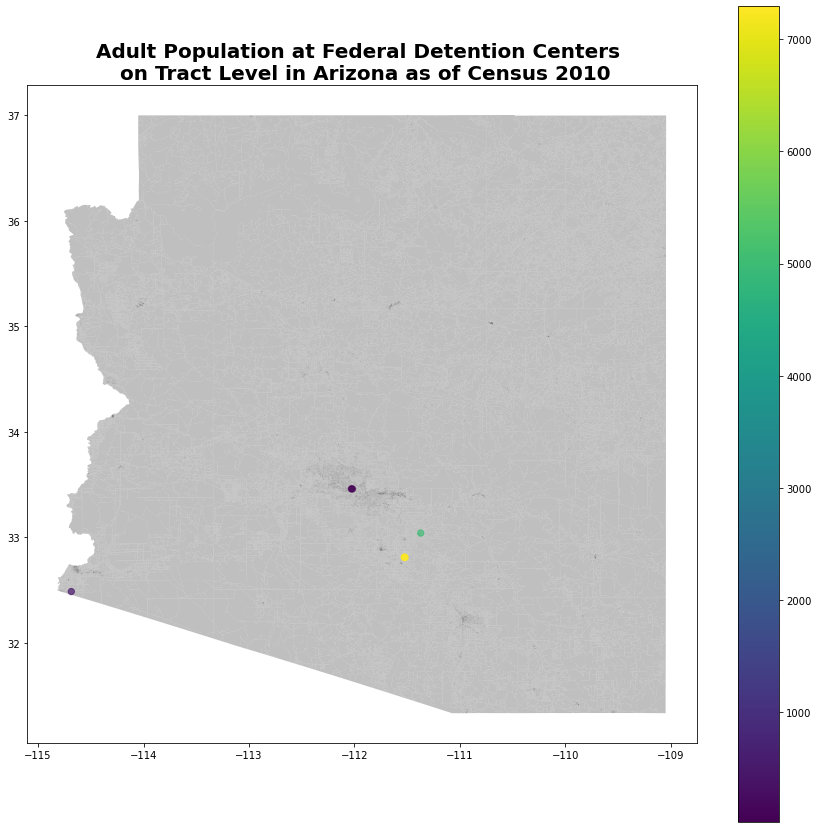

In [53]:
# Plot adult population data on an AZ map 
fig, ax = plt.subplots(figsize=(15,15))
az_map.plot(ax = ax, alpha = 0.5, color = "grey")

gdf_feddet = gdf[gdf["Federal Detention Centers - Adult Pop"] > 0]
gdf_feddet.plot(column = "Federal Detention Centers - Adult Pop", ax = ax, alpha = 0.7, markersize = 40, legend = True)
plt.title("Adult Population at Federal Detention Centers \n on Tract Level in Arizona as of Census 2010", fontsize = 20, fontweight = "bold")
plt.show()

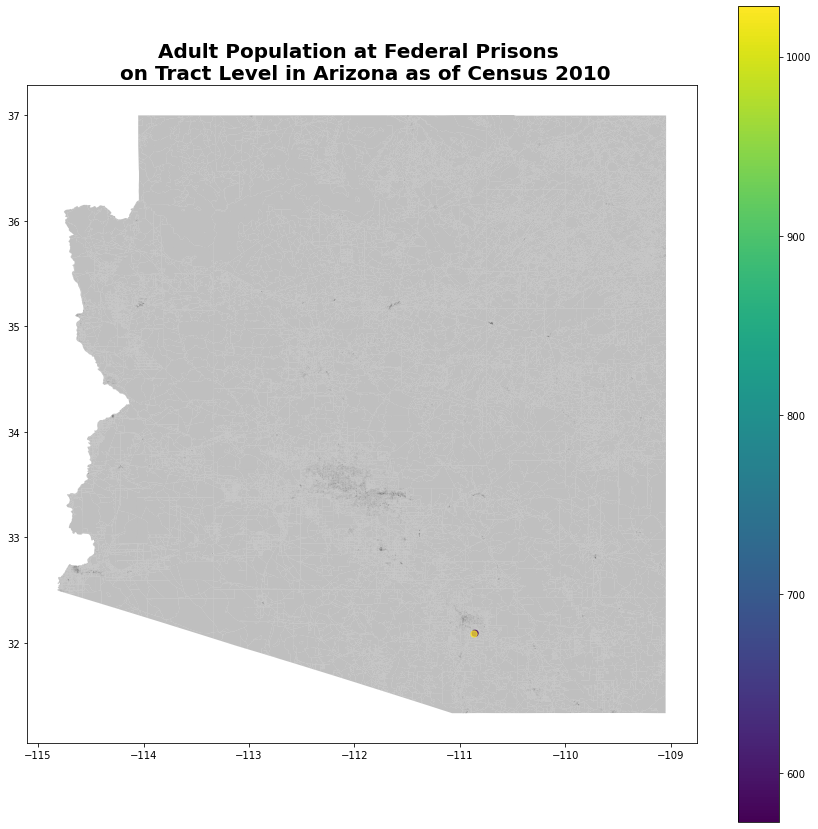

In [54]:
fig, ax = plt.subplots(figsize=(15,15))
az_map.plot(ax = ax, alpha = 0.5, color = "grey")

gdf_fedpri = gdf[gdf["Federal Prisons - Adult Pop"] > 0]
gdf_fedpri.plot(column = "Federal Prisons - Adult Pop", ax = ax, alpha = 0.7, markersize = 40, legend = True)
plt.title("Adult Population at Federal Prisons \n on Tract Level in Arizona as of Census 2010", fontsize = 20, fontweight = "bold")
plt.show()

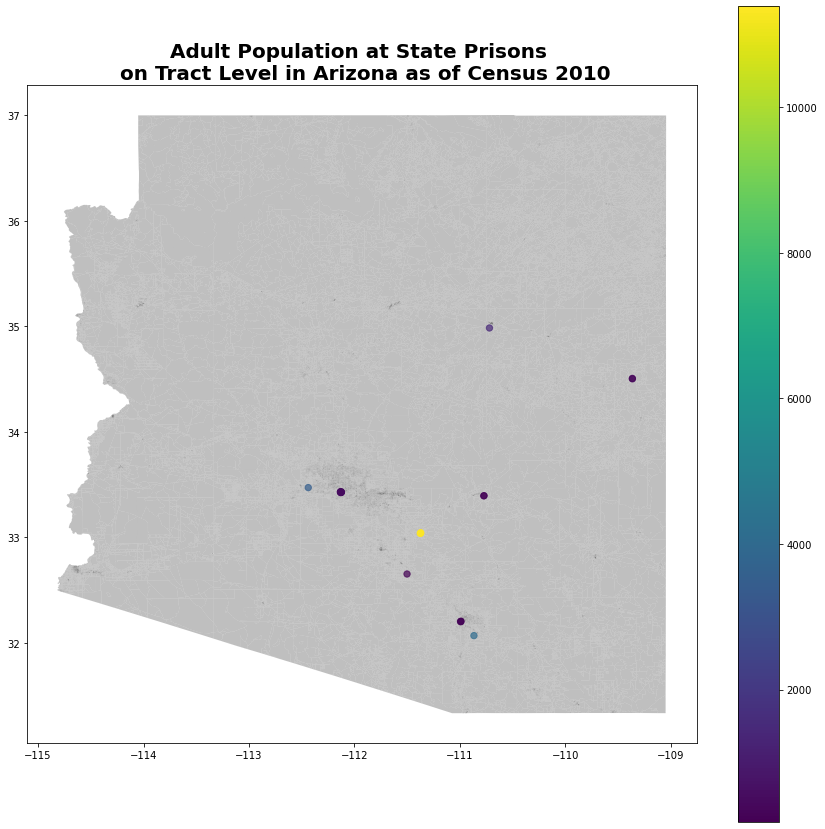

In [55]:
fig, ax = plt.subplots(figsize=(15,15))
az_map.plot(ax = ax, alpha = 0.5, color = "grey")

gdf_stpri = gdf[gdf["State Prisons - Adult Pop"] > 0]
gdf_stpri.plot(column = "State Prisons - Adult Pop", ax = ax, alpha = 0.7, markersize = 40, legend = True)
plt.title("Adult Population at State Prisons \n on Tract Level in Arizona as of Census 2010", fontsize = 20, fontweight = "bold")
plt.show()

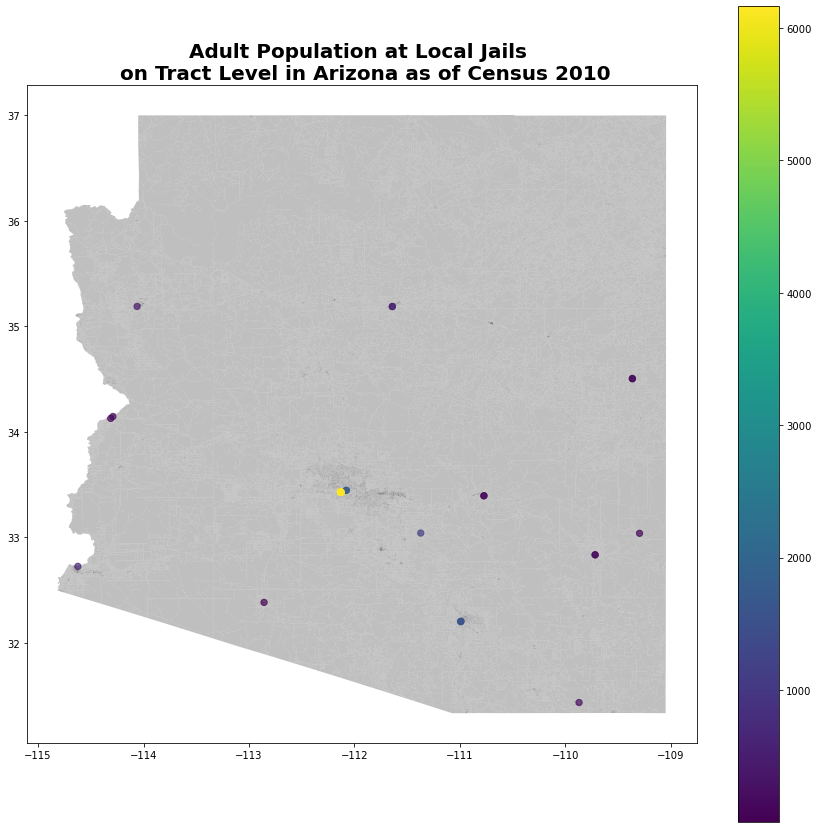

In [56]:
fig, ax = plt.subplots(figsize=(15,15))
az_map.plot(ax = ax, alpha = 0.5, color = "grey")

gdf_locpri = gdf[gdf["Local Jails - Adult Pop"] > 0]
gdf_locpri.plot(column = "Local Jails - Adult Pop", ax = ax, alpha = 0.7, markersize = 40, legend = True)
plt.title("Adult Population at Local Jails \n on Tract Level in Arizona as of Census 2010", fontsize = 20, fontweight = "bold")
plt.show()

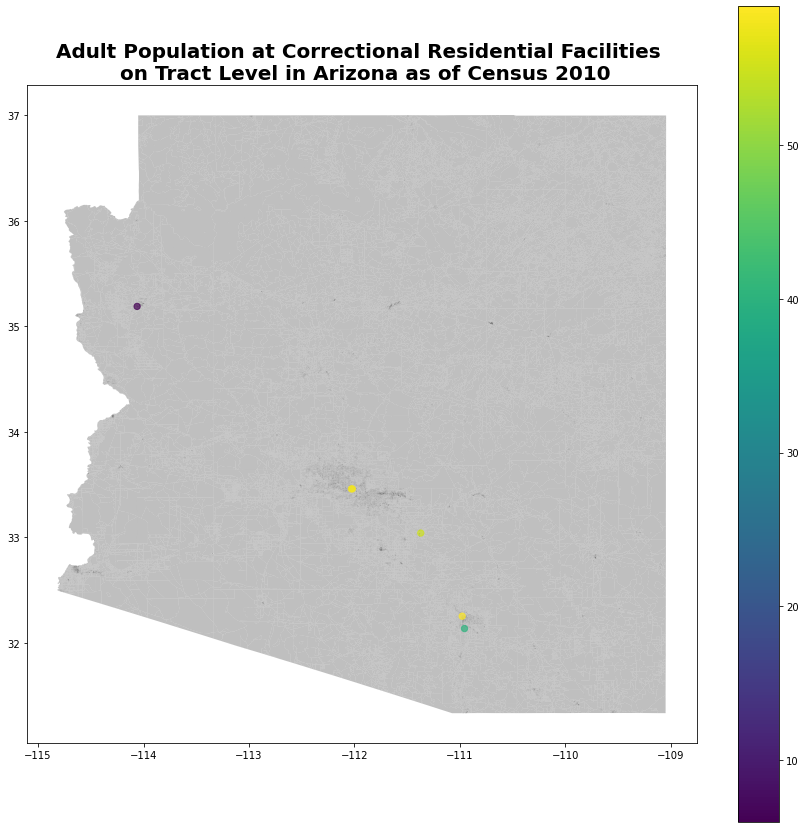

In [57]:
fig, ax = plt.subplots(figsize=(15,15))
az_map.plot(ax = ax, alpha = 0.5, color = "grey")

gdf_res = gdf[gdf["Residential - Adult Pop"] > 0]
gdf_res.plot(column = "Residential - Adult Pop", ax = ax, alpha = 0.7, markersize = 40, legend = True)
plt.title("Adult Population at Correctional Residential Facilities \n on Tract Level in Arizona as of Census 2010", fontsize = 20, fontweight = "bold")
plt.show()

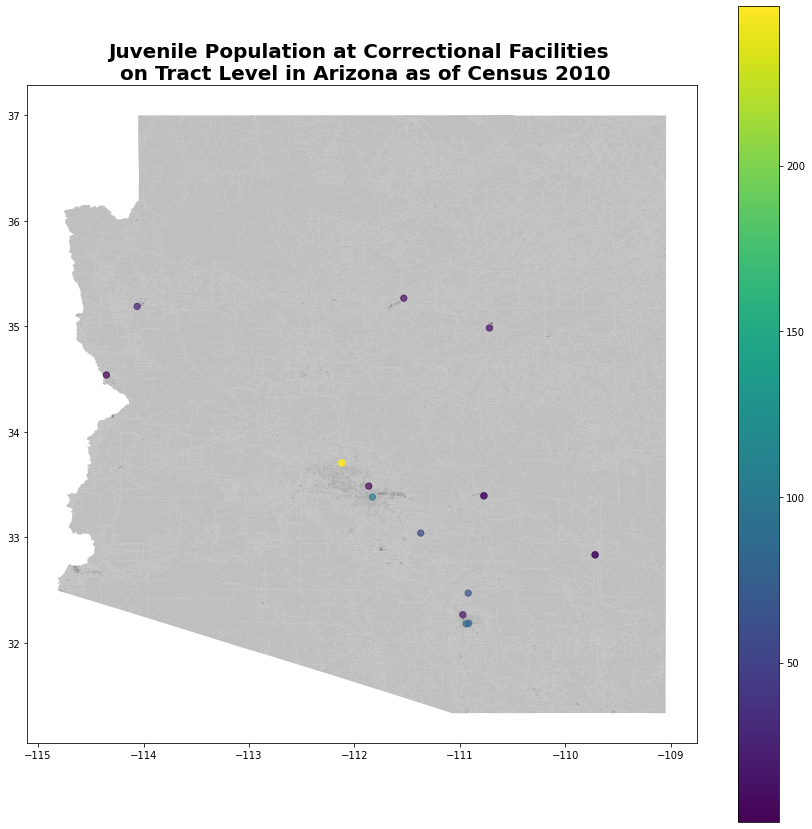

In [58]:
fig, ax = plt.subplots(figsize=(15,15))
az_map.plot(ax = ax, alpha = 0.5, color = "grey")

gdf_juv = gdf[gdf["Juvenile Pop"] > 0]
gdf_juv.plot(column = "Juvenile Pop", ax = ax, alpha = 0.7, markersize = 40, legend = True)
plt.title("Juvenile Population at Correctional Facilities \n on Tract Level in Arizona as of Census 2010", fontsize = 20, fontweight = "bold")
plt.show()